In [2]:
import csv
import torch
import utils as ut
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader


# File path (replace with the actual file path)
csv_path = "/media/maria/work_space/capsule-3259363/data/HarvardOPV_40.csv" #data/HarvardOPV_40.csv"

# Open the CSV file and process it
eval_dataset = []
with open(csv_path, newline='', encoding='utf-8') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=',')
    
    # Read the header to identify column indices
    header = next(csv_reader)
    smiles_idx = header.index("smiles")
    homo_idx = header.index("homo")
    lumo_idx = header.index("lumo")
    
    # Read each row
    for row in csv_reader:
        smiles = row[smiles_idx]
        homo = torch.tensor([float(row[homo_idx])], dtype=torch.float)  # Extract HOMO energy level
        lumo = torch.tensor([float(row[lumo_idx])], dtype=torch.float32)

        # Convert SMILES to molecular graph
        graph_data = ut.smiles_to_graph(smiles)
        if graph_data is None:
            continue  # Skip invalid molecules
        
        z, pos = graph_data
        
        # Create a PyTorch Geometric Data object
        data_entry = Data(
            pos=pos.to(torch.float32),    # Atomic positions
            z=torch.LongTensor(z),        # Atomic numbers
            y=torch.tensor([homo, lumo], dtype=torch.float32),  # Polarizability tensor (target)
        )
        
        eval_dataset.append(data_entry)



[12:48:57] UFFTYPER: Unrecognized atom type: Se2+2 (4)
[12:48:57] UFFTYPER: Unrecognized atom type: Se2+2 (4)


In [3]:

def filter_dataset(dataset):
    """ Filters out molecules with atomic numbers not in QM9 (Z > 9) """
    filtered_dataset = []
    
    for data in dataset:
        z = data.z  # Assuming SMILES is stored in the dataset
        
                
        # Check if the molecule contains any element outside QM9 limits
        if torch.max(z) > 34:
            print(f"Skipping unsupprted molecule: {z}")
            continue
        
        filtered_dataset.append(data)
    
    return filtered_dataset

# Apply filtering to eval_dataset
filtered_eval_dataset = filter_dataset(eval_dataset)

# Print how many molecules were removed
print(f"Original dataset size: {len(eval_dataset)}")
print(f"Filtered dataset size: {len(filtered_eval_dataset)}")

# Create DataLoader for evaluation
eval_loader = DataLoader(eval_dataset, batch_size=1, shuffle=False)

# Print first molecule in the dataset
print(eval_dataset[0])



Original dataset size: 162
Filtered dataset size: 162
Data(y=[2], pos=[33, 3], z=[33])


In [4]:
from detanet_model import DetaNet

# load model

device=torch.device('cpu')

trained_model=DetaNet(num_features=128,
                 act='swish',
                 maxl=3,
                 num_block=3,
                 radial_type='trainable_bessel',
                 num_radial=32,
                 attention_head=8,
                 rc=5.0,
                 dropout=0.0,
                 use_cutoff=False,
                 max_atomic_number=34,
                 atom_ref=None,
                 scale=None,
                 scalar_outsize=2,
                 irreps_out=None,
                 summation=False,
                 norm=False,
                 out_type='scalar',
                 grad_type=None ,
                 device=torch.device(device))
state_dict = torch.load("/media/maria/work_space/capsule-3259363/code/trained_param/homo_lumo.pth")
trained_model.load_state_dict(state_dict=state_dict)

/tmp/ipykernel_42620/588091135.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/media/maria/work_space/capsule-3259363/code/trained_param/homo_

<All keys matched successfully>

In [5]:
for batch in eval_loader:
    print("Atomic numbers in batch:", batch.z.tolist())
      # Print only the first batch


Atomic numbers in batch: [6, 6, 6, 16, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 16, 6, 7, 16, 7, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Atomic numbers in batch: [6, 7, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 16, 6, 16, 6, 6, 6, 14, 6, 6, 16, 7, 6, 6, 8, 6, 6, 6, 6, 6, 6, 16, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Atomic numbers in batch: [6, 6, 6, 6, 6, 6, 16, 6, 16, 6, 6, 6, 6, 16, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 7, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Atomic numbers in batch: [6, 6, 6, 6, 16, 6, 6, 7, 6, 16, 6, 6, 16, 6, 6, 6, 6, 6, 6, 6, 7, 6, 16, 6, 6, 16, 6, 6, 6, 6, 7, 6, 16, 16, 6, 6, 6, 7, 6, 16, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Atomic numbers in batch: [6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 8, 8, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Atomic numbers in batch: [6, 8, 6, 6, 6, 6, 7, 6, 6, 6, 6, 8, 

In [9]:
import torch
import torch.nn.functional as F

# **L2 Loss (MSE - Mean Squared Error)**
def l2loss(pred, target):
    return F.mse_loss(pred, target)

# **L1 Loss (MAE - Mean Absolute Error)**
def l1loss(pred, target):
    return F.l1_loss(pred, target)

# **R² Score**
def R2(pred, target):
    mean_target = torch.mean(target)
    ss_total = torch.sum((target - mean_target) ** 2)
    ss_residual = torch.sum((target - pred) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    return r2

🔹 Total L2 Loss (MSE): 13.619577
🔹 Total L1 Loss (MAE): 3.226496
🔹 Total R² Score: -744.977783
val_loss:13.61957741,val_mae:3.22649622,val_R2:-744.97778320


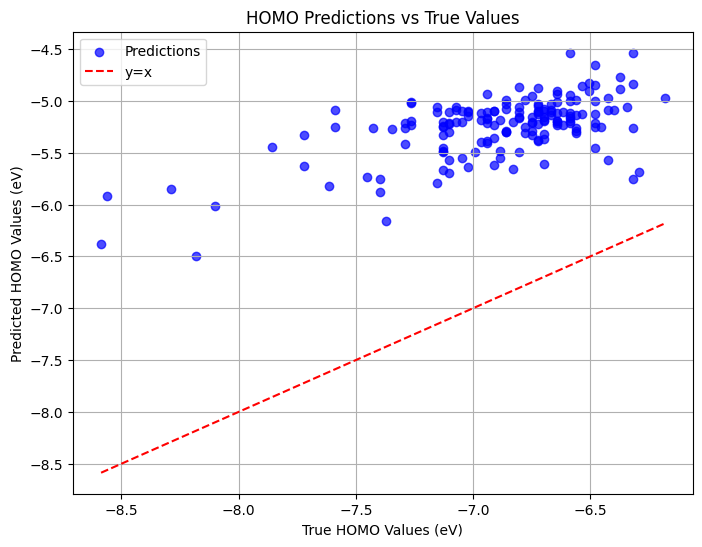

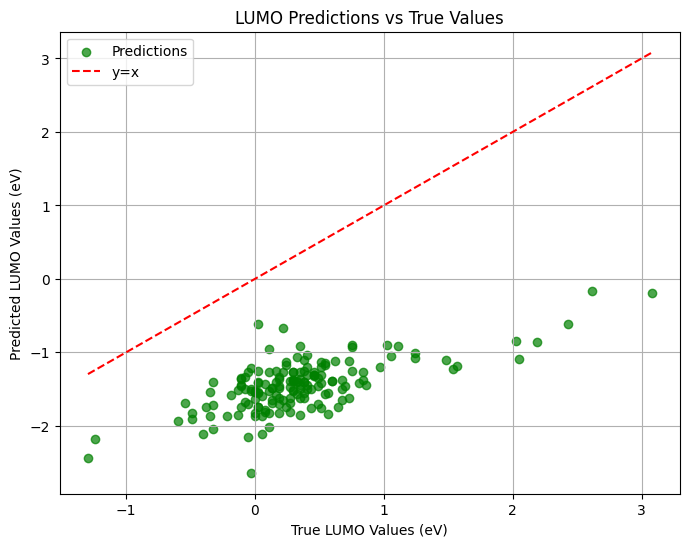

In [11]:
import matplotlib.pyplot as plt
import torch
from torch_geometric.nn import global_mean_pool

# Initialize lists for predictions and true values
predictions = []
true_values = []

# Iterate through the validation dataset
for batch in eval_loader:
    true_values.append(batch.y.unsqueeze(0))  # Directly store batch.y (corrected)
    with torch.no_grad():
        val_out = trained_model(
            pos=batch.pos.to(device), 
            z=batch.z.to(device),
            batch=batch.batch.to(device)
        )
        val_graph_out = global_mean_pool(val_out, batch.batch)  # Aggregate node-level outputs
        predictions.append(val_graph_out)

# Convert lists of tensors to a single tensor
true_values = torch.cat(true_values, dim=0).cpu()  # Shape: [num_samples, 2]
predictions = torch.cat(predictions, dim=0).cpu()  # Shape: [num_samples, 2]

# Separate HOMO and LUMO values
true_homo_values = true_values[:, 0] * 27  # Convert to eV
true_lumo_values = true_values[:, 1] * 27  # Convert to eV
predictions_homo_values = predictions[:, 0] 
predictions_lumo_values = predictions[:, 1] 

# **✅ Compute overall dataset losses**
total_l2_loss = l2loss(predictions, true_values).item()  # MSE
total_l1_loss = l1loss(predictions, true_values).item()  # MAE
total_r2 = R2(predictions, true_values).item()  # R² Score

# **📌 Print total loss values**
print(f"🔹 Total L2 Loss (MSE): {total_l2_loss:.6f}")
print(f"🔹 Total L1 Loss (MAE): {total_l1_loss:.6f}")
print(f"🔹 Total R² Score: {total_r2:.6f}")
print("val_loss:{:.8f},val_mae:{:.8f},val_R2:{:.8f}".format(total_l2_loss, total_l1_loss, total_r2))

# **🔵 Plot HOMO results**
plt.figure(figsize=(8, 6))
plt.scatter(true_homo_values, predictions_homo_values, c='blue', alpha=0.7, label='Predictions')
plt.plot([min(true_homo_values), max(true_homo_values)], [min(true_homo_values), max(true_homo_values)], color='red', linestyle='--', label='y=x')
plt.xlabel('True HOMO Values (eV)')
plt.ylabel('Predicted HOMO Values (eV)')
plt.title('HOMO Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

# **🟢 Plot LUMO results**
plt.figure(figsize=(8, 6))
plt.scatter(true_lumo_values, predictions_lumo_values, c='green', alpha=0.7, label='Predictions')
plt.plot([min(true_lumo_values), max(true_lumo_values)], [min(true_lumo_values), max(true_lumo_values)], color='red', linestyle='--', label='y=x')
plt.xlabel('True LUMO Values (eV)')
plt.ylabel('Predicted LUMO Values (eV)')
plt.title('LUMO Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()
